
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

### Sequential Gaussian Simulation for Geostatistical Realizations 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Here's a simple workflow for spatial simulation with sequential Gaussian simulation. This step is critical for:

1. Prediction away from wells, e.g. pre-drill assessments, with uncertainty 
2. Spatial uncertainty modeling.
3. Heterogeneity realizations ready for application to the transfer function.

First let's explain the concept of spatial simulation.

#### Spatial Simulation

For more information see this lecture on geostatistical simulation and sequential Gaussian simulation.

* [Simulation](https://www.youtube.com/watch?v=3cLqK3lR56Y&list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ&index=45)


#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_MV_biased.csv available at https://git.io/fhgu0.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Load the Required Libraries

The following code loads the required libraries including my GeostatsPy package.

In [1]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

In [3]:
def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill):     # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.01,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
    plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.01,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
    plt.plot(lags_min,gmod_min,color = 'red')
    plt.plot([0,2000],[sill,sill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    plt.grid(True)

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [4]:
#os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extract a limited sample to reduce data density. This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [5]:
unconditional = False
#df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df = df.drop(['index','Unnamed: 0'],axis=1)               # remove extra columns in DataFrame
df['logPerm'] = np.log(df['Perm'].values)                 # calculate the log of permeability
if unconditional == True:
    df['X'] = df['X'] + 9999999.9                        # move the data outside the model, just use the distributions
df.describe()  # summary statistics 
df.head()

,X,Y,Facies,Porosity,Perm,AI,logPerm
0,80.0,339.0,1.0,0.097085,1.157147,5861.952750,0.145957
1,830.0,819.0,1.0,0.124873,1.782012,4494.808666,0.577743
2,110.0,49.0,0.0,0.088687,2.421278,6658.973916,0.884296
3,160.0,579.0,1.0,0.156645,71.673783,3180.807532,4.272125
4,300.0,679.0,1.0,0.168196,602.656287,3766.141917,6.401347


#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test, comparision of simulation with simple and ordinary kriging.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1279
                 Weighted Variance             = 0.0011
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.142 (close to 0.0?)
                                   variance = 0.8222 (close to gammabar(V,V)? approx. 1.0)
 x,y,z offsets = 10.0,1.794896514920806e-08
 x,y,z offsets = 3.589793029841612e-08,-10.0


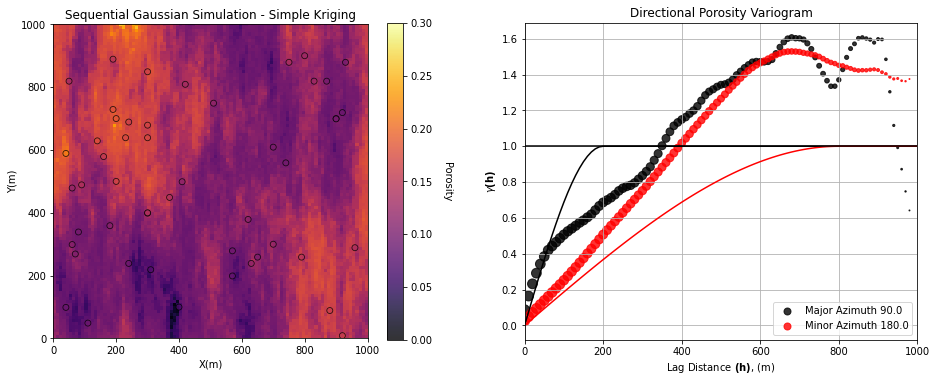

In [6]:
# Simple Kriging vs. Ordinary Kriging
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 10000; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=800,hmin1=200)
tmin = -999; tmax = 999

sim_sk = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=1,nmult=3,noct=-1,radius=radius,radius1=100000,sang1=0,
            mxctx=81,mxcty=81,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

# sim_ok = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
#             twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
#             nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
#             ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
#             mxctx=10,mxcty=10,ktype=1,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(121)                                          # plot the results
GSLIB.locpix_st(sim_sk,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
# plt.subplot(222)
# GSLIB.locpix_st(sim_ok,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Ordinary Kriging','X(m)','Y(m)','Porosity',cmap)

lags, gamma_x, npps_x = geostats.gam(sim_sk,-9999.9,9999.9,xsiz,ysiz,ixd=1,iyd=0,nlag=100,isill=1)
lags, gamma_y, npps_y = geostats.gam(sim_sk,-9999.9,9999.9,xsiz,ysiz,ixd=0,iyd=1,nlag=100,isill=1)

plt.subplot(122)
vargplot('Porosity',lags,gamma_x,gamma_y,npps_x,npps_y,vario,azi=90.0,atol=22.5,sill=1.0)     # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Exploring Geometric Anisotropy

Le'ts look at 4 realizations of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1279
                 Weighted Variance             = 0.0011
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0001 (close to 0.0?)
                                   variance = 0.8131 (close to gammabar(V,V)? approx. 1.0)


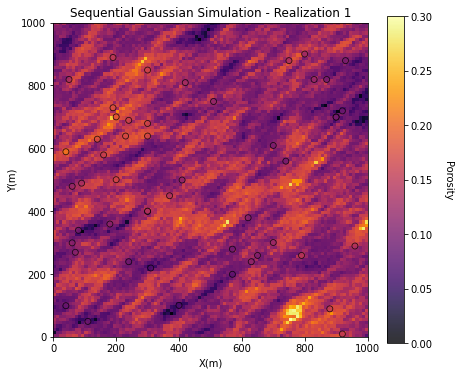

In [7]:
# Strongly Anisotropic Realization
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 800; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=200,hmin1=50)
tmin = -999; tmax = 999

sim_anis = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim_anis,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Exploring Multiple Realizations

Let's look at 4 realizations of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1279
                 Weighted Variance             = 0.0011
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1654 (close to 0.0?)
                                   variance = 0.9777 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
       

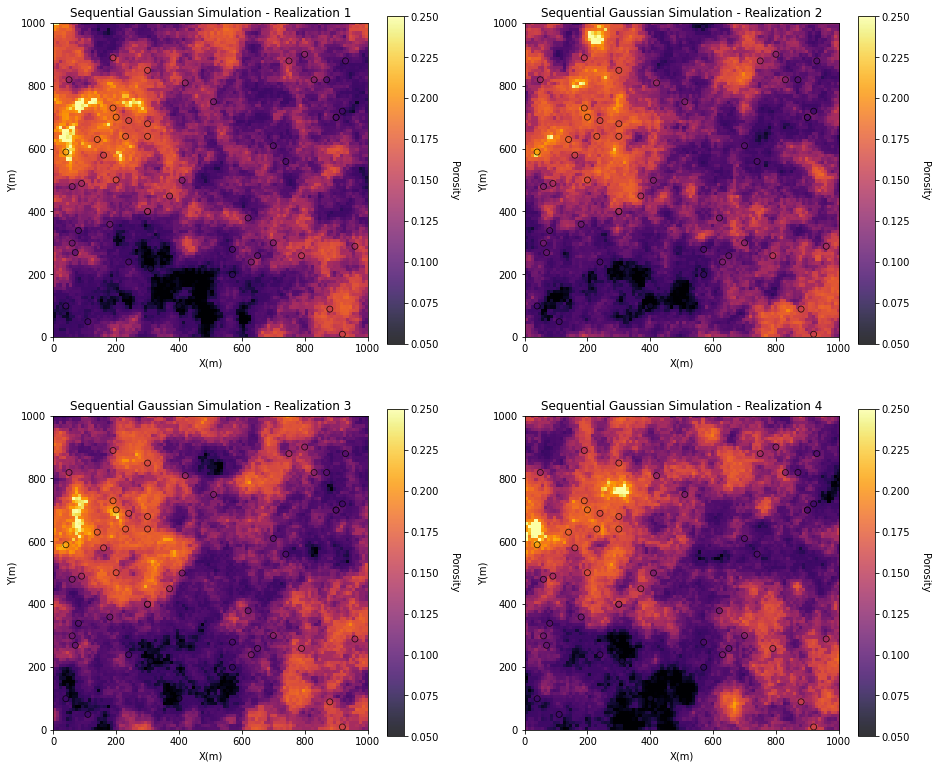

In [8]:
# Demonstration of Multiple Realizations - Short Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 300; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=300,hmin1=300)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

Let's look at 4 realizations of porosity all with long range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1279
                 Weighted Variance             = 0.0011
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1847 (close to 0.0?)
                                   variance = 1.0031 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
       

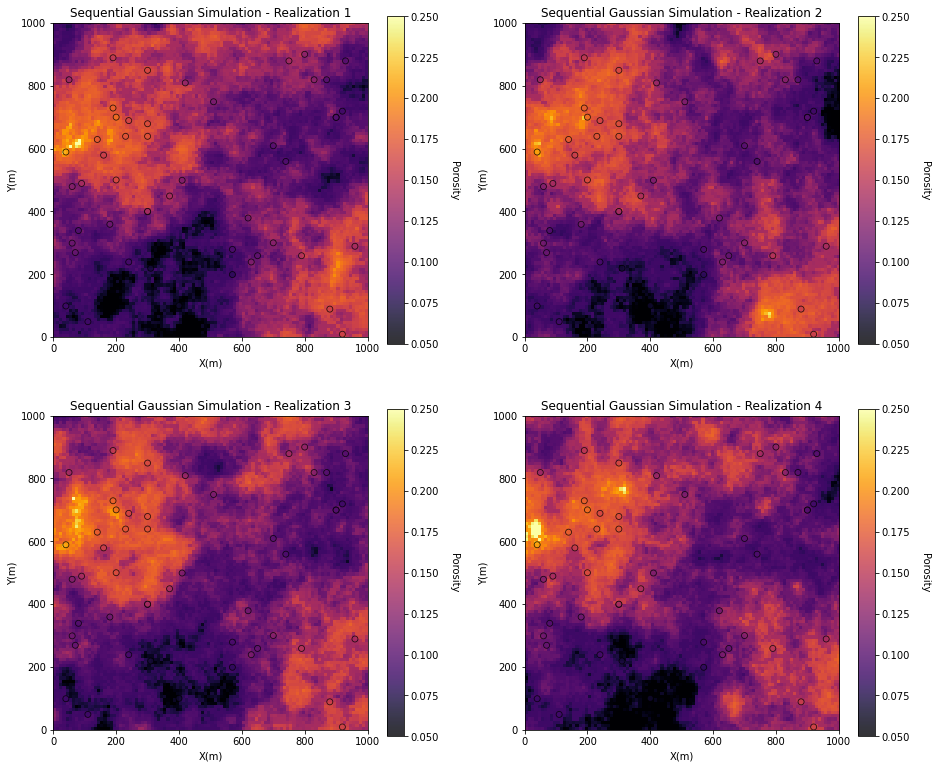

In [9]:
# Demonstration of Multiple Realizations - Long Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 500; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=500,hmin1=500)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Sequential Gaussian Simulation - Collocated Cokriging

Now let's demonstrate collocated cokriging.  We first calculate a realization of porosity and then collocated cokriging realization of permeability constrained to the porosity realizations.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1279
                 Weighted Variance             = 0.0011
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0085 (close to 0.0?)
                                   variance = 0.9237 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
        

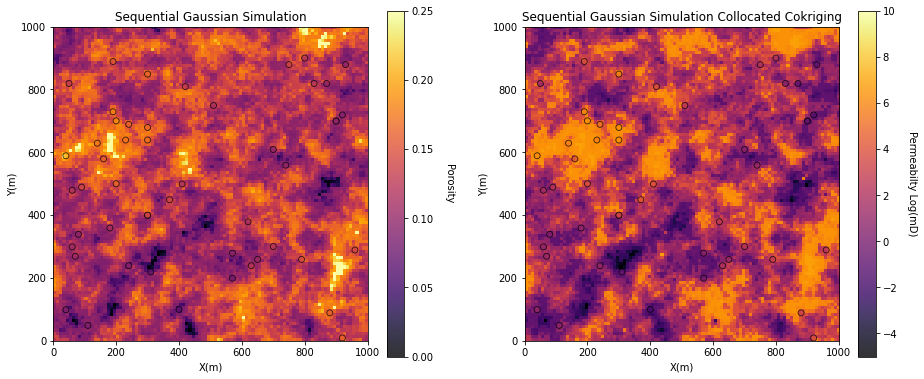

In [10]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=100)
tmin = -99999; tmax = 99999

trend = np.zeros((ny,nx))
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix] = -1*(iy-ny/2)/(ny)*0.03+.127
#trend = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]) 
    
sim_por = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=trend,vario=vario)

sim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=0.9,sec_map=sim_por,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(121)
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,0.0,0.250,df,'X','Y','Porosity','Sequential Gaussian Simulation','X(m)','Y(m)','Porosity',cmap)
sim_log_perm = np.log(sim_perm.clip(0.0001,1200))
plt.subplot(122)
GSLIB.locpix_st(sim_log_perm,xmin,xmax,ymin,ymax,xsiz,-5.0,10,df,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Facies-based Simulation

Let's simulate a single realization of a facies model with sequential indicator simulation.

* We will assign the facies based on the most probable between sand and shale at each location

Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


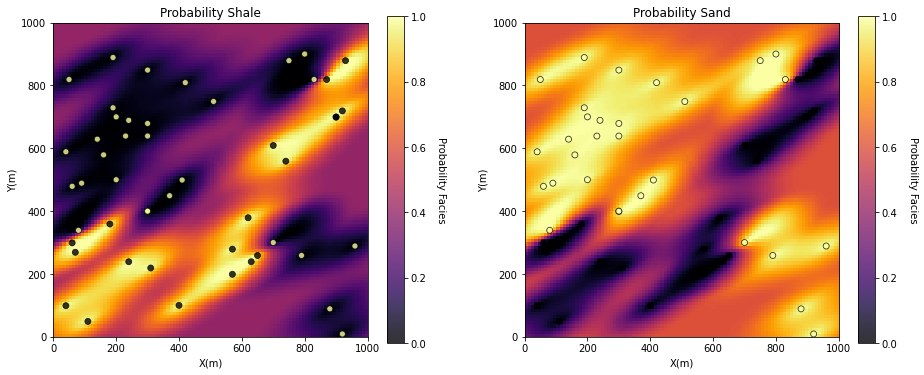

In [11]:
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.4,0.6]                           # the global proportions of the categories
varios_facies = []                                # the variogram list
varios_facies.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60,hmaj1=300,hmin1=100)) # shale indicator variogram
varios_facies.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60,hmaj1=300,hmin1=100)) # sand indicator variogram
no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will NOT use a trend - will fix this
ktype = 0; ivtype = 0                       # simple kriging, categorical feature
ikmap = geostats.ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,-999,999,nx,xmn,xsiz,ny,ymn,ysiz,
                      ndmin,70,400,ktype,vario=varios_facies)

plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2) 
plt.show()

#### Cookie Cutter Porosity-by Facies Realization

Use the cookie cutter approach to calculate a single porosity realization.

* simulate porosity by-facies, sand and shale at all locations
* at each location find the facies from the facies realization and assign the porosity realization from the associated by-facies porosity realization

This approach causes discontinuities at the facies boundaries

* porosity spatial continuity may not conform with the facies boundaries

In [12]:
simulate = False
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records

skmean_por_sand = 0.14; skmean_por_shale = 0.08
ndmin = 0; ndmax = 20; radius = 600; ktype = 1
por_sand_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,hmaj1=600,hmin1=100) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,hmaj1=600,hmin1=100) # porosity shale variogram

facies_sim = np.zeros((ny,nx)); por_sim = np.zeros((ny,nx)); # declare array to combine values

if simulate == True:
    por_sand_sim = geostats.sgsim(df_sand,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
            dftrans=0,tcol=0,
            twtcol=0,zmin=0.1,zmax=0.3,ltail=1,ltpar=0.1,utail=1,utpar=0.23,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=trend,vario=por_sand_vario)

    por_shale_sim = geostats.sgsim(df_shale,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
            dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.13,ltail=1,ltpar=0.0,utail=1,utpar=0.13,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=trend,vario=por_shale_vario)

for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_sim[iy,ix] = 1
            por_sim[iy,ix] = por_sand_sim[iy,ix];
        else:                      # current location is assumed to be shale
            facies_sim[iy,ix] = 0
            por_sim[iy,ix] = por_shale_sim[iy,ix];

plt.subplot(221)
GSLIB.locpix_st(por_sand_sim,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_sand,'X','Y','Porosity','Sand Porosity Realization','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.locpix_st(por_shale_sim,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_shale,'X','Y','Porosity','Shale Porosity Realization','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.locpix_st(facies_sim,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Facies ','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)
plt.scatter(df_shale['X'],df_shale['Y'],color='black',edgecolor='white',linewidth=0.8)

plt.subplot(224)
GSLIB.locpix_st(por_sim,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_shale,'X','Y','Porosity','All Facies Porosity Realization','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=-0.1, hspace=0.3)
plt.show()

NameError: name 'por_sand_sim' is not defined

#### Comments

This was a basic demonstration of spatial simulation. I know the simulation program is rough and the code needs some clean up, but we are getting to the point where we have a function package for Geostatistics in Python.  

Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
